In [15]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [16]:
train_path="C:\\Users\\adnan\\OneDrive\\Desktop\\data1\\train"
test_path="C:\\Users\\adnan\\OneDrive\\Desktop\\data1\\test"
valid_path="C:\\Users\\adnan\\OneDrive\\Desktop\\data1\\val"
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
ht=0
wt=0
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [17]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [18]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):#
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) 
      
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') 
    for label in df['labels'].unique():               
        group=groups.get_group(label)  
        sample_count=len(group)     
        if sample_count< n: 
            aug_img_count=0
            delta=n - sample_count  
            target_dir=os.path.join(aug_dir, label)  
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') 
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=500 
working_dir=r'./' 
img_size=(224,224) 
train_df=balance(train_df, n, working_dir, img_size)    

Initial length of dataframe is  2173
Found 173 validated image filenames.     for class             Severe             creating  327  augmented images 
Total Augmented images created=  327
Length of augmented dataframe is now  2500


In [19]:
batch_size=20   
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') 
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') 
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 2500 validated image filenames belonging to 5 classes.           for train generator 
Found 826 validated image filenames belonging to 5 classes.            for valid generator 
Found 1656 validated image filenames belonging to 5 classes.           for test generator 
test batch size:  72   test steps:  23  number of classes :  5


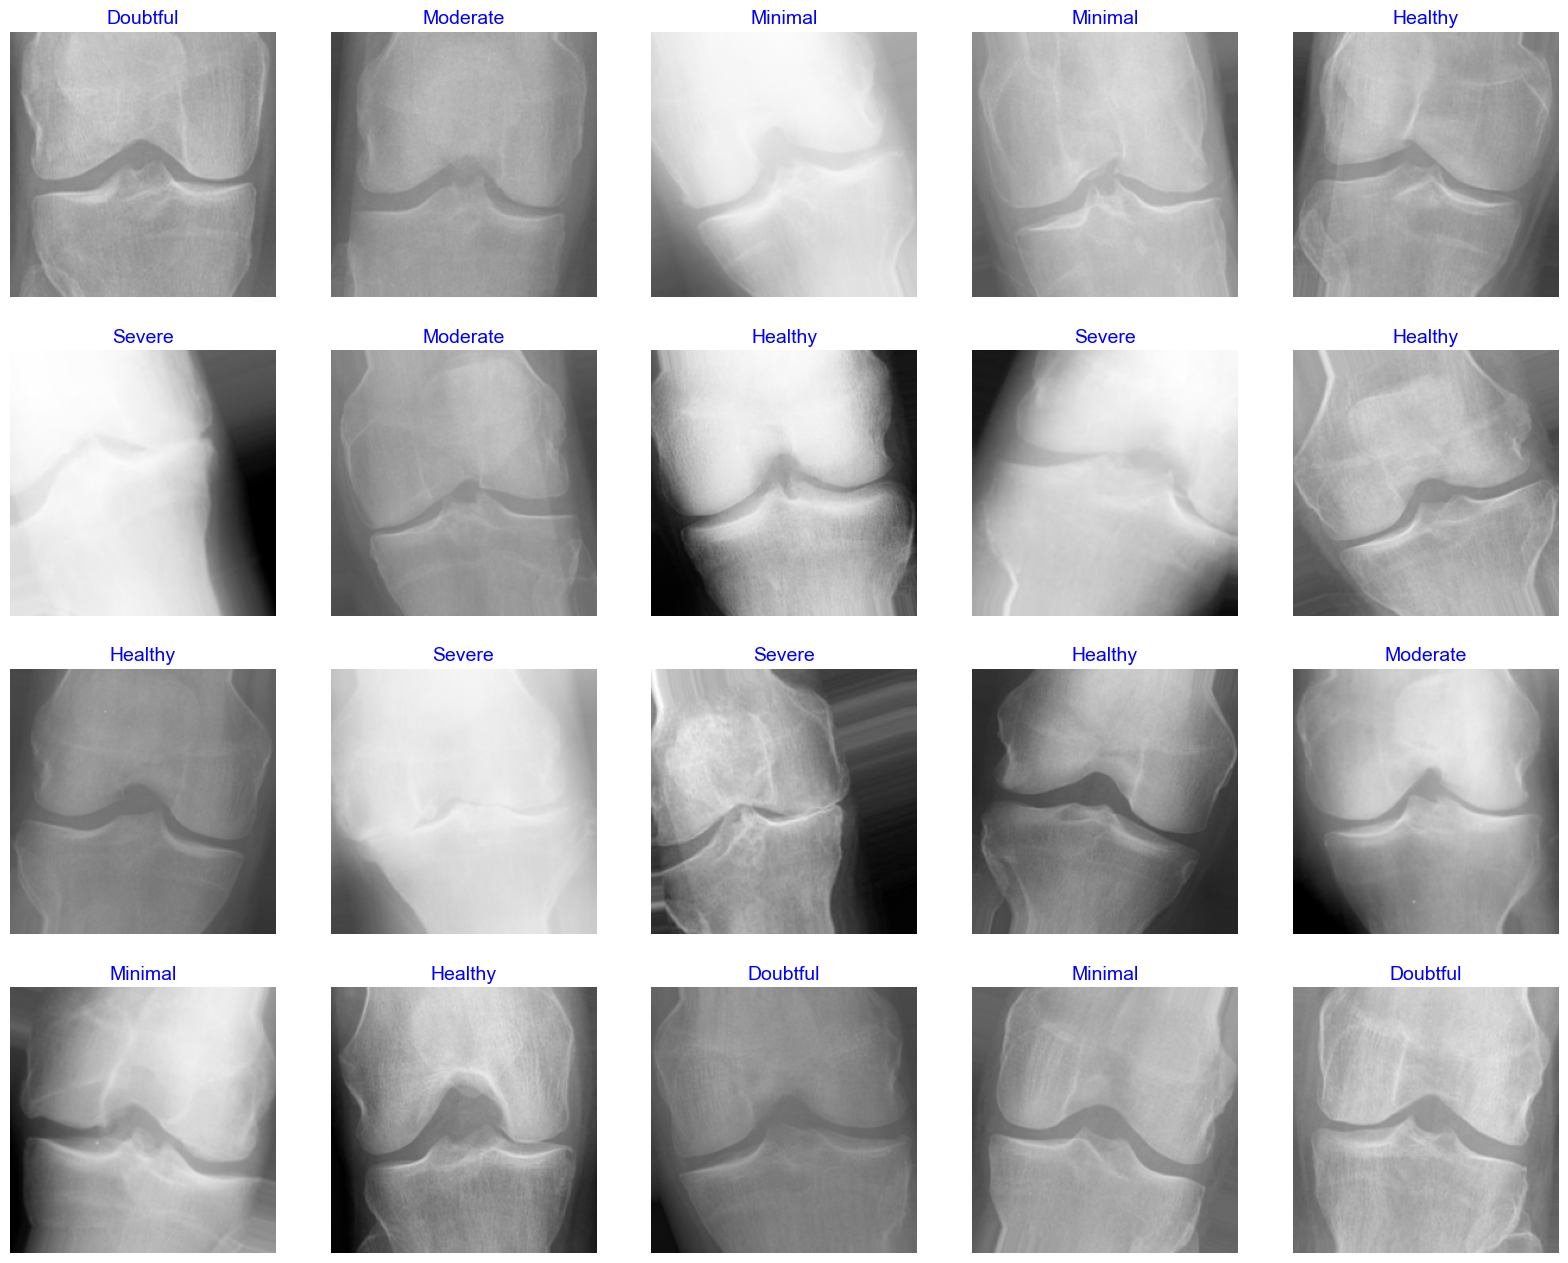

In [20]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen)  
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [21]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 




In [33]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


for epoch in range(len(train_acc)):
    print("Epoch {}: Training Accuracy = {:.2f}%, Validation Accuracy = {:.2f}%"
          .format(epoch+1, train_acc[epoch]*100, val_acc[epoch]*100))

Epoch 1: Training Accuracy = 37.44%, Validation Accuracy = 43.10%
Epoch 2: Training Accuracy = 47.92%, Validation Accuracy = 48.18%
Epoch 3: Training Accuracy = 53.64%, Validation Accuracy = 57.02%
Epoch 4: Training Accuracy = 60.32%, Validation Accuracy = 60.53%
Epoch 5: Training Accuracy = 63.72%, Validation Accuracy = 58.60%
Epoch 6: Training Accuracy = 66.24%, Validation Accuracy = 58.47%
Epoch 7: Training Accuracy = 69.24%, Validation Accuracy = 57.87%
Epoch 8: Training Accuracy = 70.72%, Validation Accuracy = 54.84%
Epoch 9: Training Accuracy = 72.48%, Validation Accuracy = 50.73%
Epoch 10: Training Accuracy = 74.88%, Validation Accuracy = 52.54%
Epoch 11: Training Accuracy = 77.20%, Validation Accuracy = 59.20%
Epoch 12: Training Accuracy = 77.20%, Validation Accuracy = 60.05%
Epoch 13: Training Accuracy = 80.36%, Validation Accuracy = 49.03%
Epoch 14: Training Accuracy = 82.72%, Validation Accuracy = 48.18%
Epoch 15: Training Accuracy = 84.56%, Validation Accuracy = 48.31%
Epoc

In [23]:
epochs=40
history=model.fit(x=train_gen,  epochs=epochs, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/40
125/125 [==============================] - 990s 7s/step - loss: 9.1275 - accuracy: 0.3744 - val_loss: 7.5590 - val_accuracy: 0.4310
Epoch 2/40
125/125 [==============================] - 900s 7s/step - loss: 6.8829 - accuracy: 0.4792 - val_loss: 6.1552 - val_accuracy: 0.4818
Epoch 3/40
125/125 [==============================] - 908s 7s/step - loss: 5.6944 - accuracy: 0.5364 - val_loss: 5.2257 - val_accuracy: 0.5702
Epoch 4/40
125/125 [==============================] - 904s 7s/step - loss: 4.7681 - accuracy: 0.6032 - val_loss: 4.3866 - val_accuracy: 0.6053
Epoch 5/40
125/125 [==============================] - 905s 7s/step - loss: 4.0098 - accuracy: 0.6372 - val_loss: 3.8179 - val_accuracy: 0.5860
Epoch 6/40
125/125 [==============================] - 899s 7s/step - loss: 3.3814 - accuracy: 0.6624 - val_loss: 3.2460 - val_accuracy: 0.5847
Epoch 7/40
125/125 [==============================] - 901s 7s/step - loss: 2.8432 - accuracy: 0.6924 - val_loss: 2.8236 - val_accuracy: 0.5787

In [62]:

tf.saved_model.save(model, f"{model_name}_saved_model")

loaded_model = tf.saved_model.load(f"{model_name}_saved_model")

INFO:tensorflow:Assets written to: EfficientNetB5_saved_model\assets


INFO:tensorflow:Assets written to: EfficientNetB5_saved_model\assets


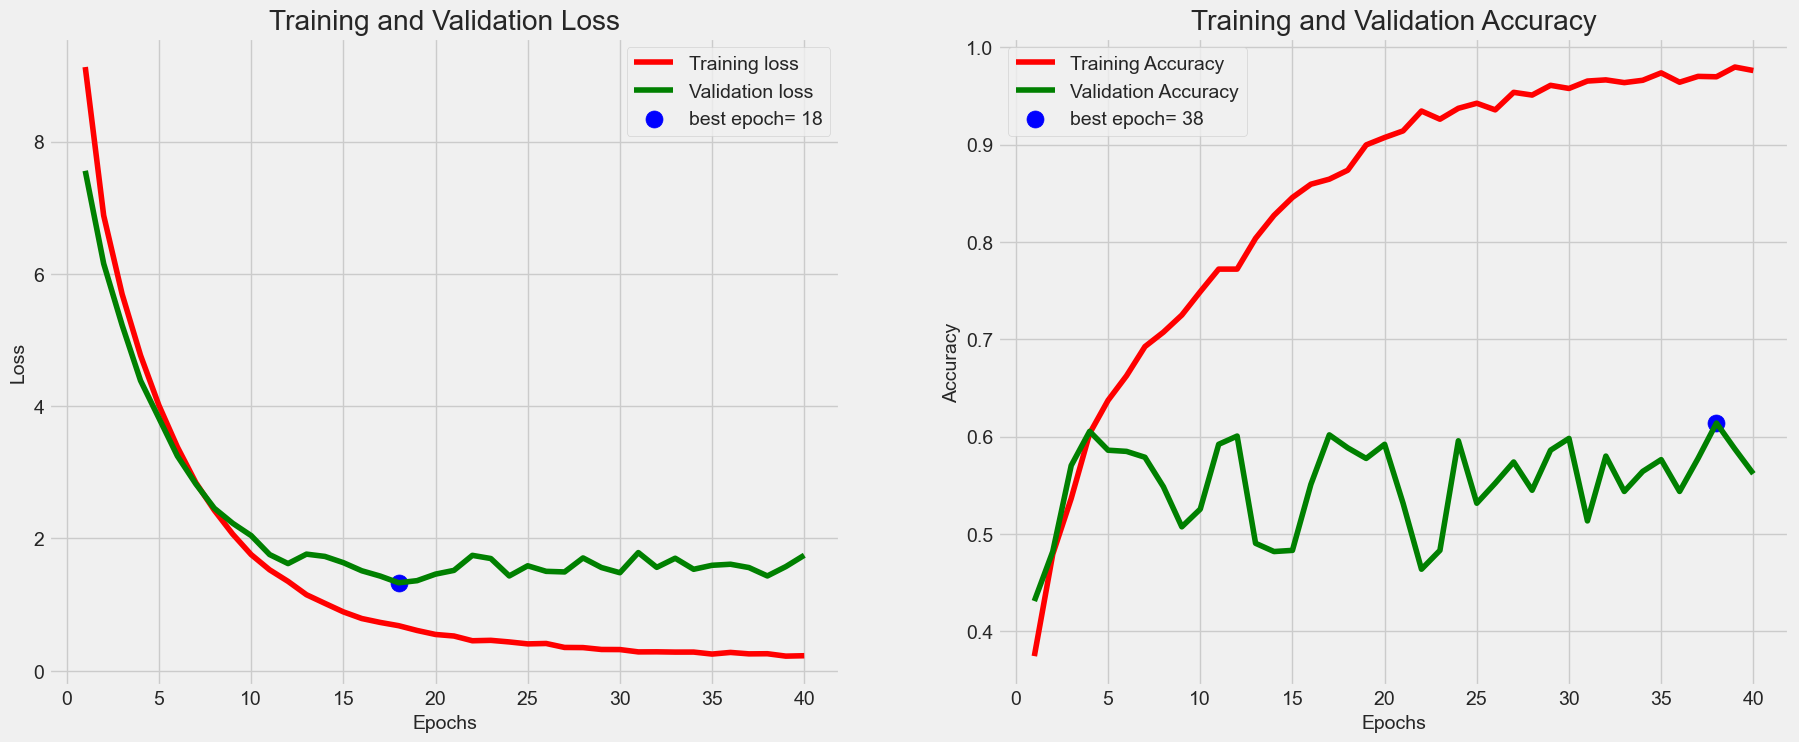

In [63]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

23/23 [==============================] - 254s 11s/step
there were 711 errors in 1656 tests for an accuracy of  57.07


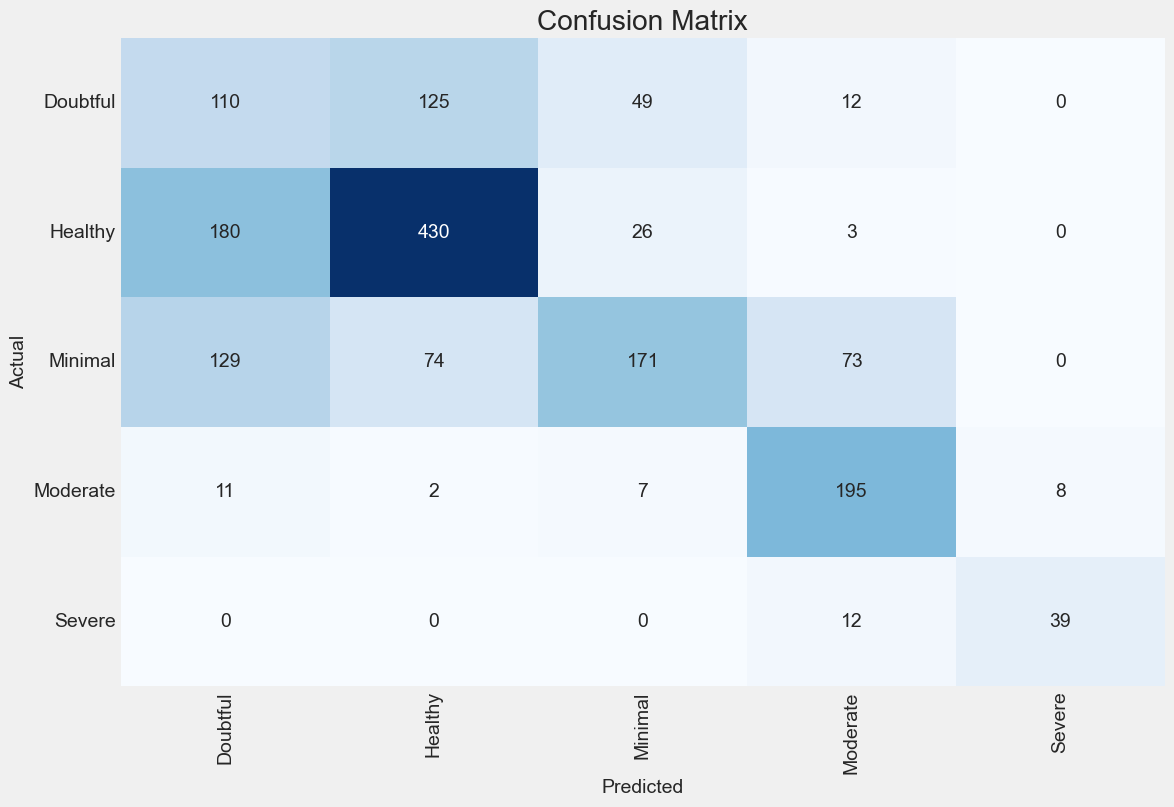

Classification Report:
----------------------
               precision    recall  f1-score   support

    Doubtful     0.2558    0.3716    0.3030       296
     Healthy     0.6815    0.6729    0.6772       639
     Minimal     0.6759    0.3826    0.4886       447
    Moderate     0.6610    0.8744    0.7529       223
      Severe     0.8298    0.7647    0.7959        51

    accuracy                         0.5707      1656
   macro avg     0.6208    0.6132    0.6035      1656
weighted avg     0.6057    0.5707    0.5732      1656



In [65]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]       
        if pred_index != true_index:                                         
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

1/1 [==============================] - 2s 2s/step
Predicted class: Doubtful
Probability: 0.8850


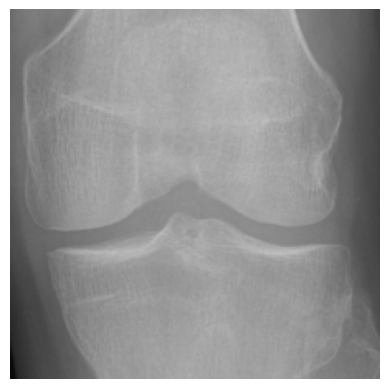

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


img_size = (224, 224)


class_names = ['Doubtful', 'Healthy' ,'Minimal', 'Moderate', 'Severe']


model = tf.keras.models.load_model("C:\\Users\\adnan\\my_model.h5")


img = tf.keras.preprocessing.image.load_img('C:\\Users\\adnan\\OneDrive\\Desktop\\data1\\test\\1\\9008934L.png', target_size=img_size)
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.efficientnet.preprocess_input(img)


prediction = model.predict(img)


predicted_class = np.argmax(prediction)


print(f'Predicted class: {class_names[predicted_class]}')
print(f'Probability: {prediction[0][predicted_class]:.4f}')
                     

plt.imshow(tf.keras.preprocessing.image.load_img('C:\\Users\\adnan\\OneDrive\\Desktop\\data1\\test\\1\\9008934L.png'))
plt.axis('off')
plt.show()
